# Metrics per Contamination Estimation (Figures 2 and 3)
Shows the evolution of different metrics (F1-score, precision, recall) according to the estimated contamination rate.

Also produces an example of a ROC curve and a precision recall curve.


You can change the dataset by changing the *dataset_name* variable in the second cell of the notebook.

In [1]:
import os
import sys

import numpy as np
from tqdm import tqdm

from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

from utils.datasets import load_dataset, normalize_data
from utils.helpers import get_threshold, get_subset
from utils.protocols import algo1
from utils.scores import get_precision_recall_f1score

In [2]:
img_format = 'pdf'
dpi = 512

# Choose the dataset to analyse
dataset_name = "arrhythmia"  # "arrhythmia", "thyroid" or "kddcup"
fig_title = {
    "thyroid": "Thyroid",
    "arrhythmia": "Arrhythmia",
    "kddcup": "KDD Cup"
}

## Impact of the contamination rate estimation
Runs an analysis of the precision, recall and F1-score for different contamination rate estimations

In [3]:
n_runs = 100  # number of runs to do to have a good std estimation
n_points = 100  # number of points calculated to draw each curve

### Computations

In [4]:
x, y = load_dataset(dataset_name)
true_ratio = (np.sum(y) / len(y))

ratio_min = 0.0
ratio_max = 3*true_ratio

ratios = np.linspace(ratio_min, ratio_max, num=n_points)

all_precisions = np.zeros((n_points, n_runs))
all_recalls = np.zeros((n_points, n_runs))
all_f1_scores = np.zeros((n_points, n_runs))

for j in tqdm(range(n_runs)):
    clf = OneClassSVM(gamma="auto", nu=0.9)
    x_run, y_run = get_subset(x, y) if dataset_name == "kddcup" else (x.copy(), y.copy())
    labels, scores, _ = algo1(x_run, y_run, test_size=0.5, model=clf, compute_metrics=False)
    
    for i, ratio in enumerate(ratios):
        # Get the threshold
        thresh = get_threshold(scores, ratio)
        pred = (scores >= thresh).astype(int)

        precision, recall, f1_score = get_precision_recall_f1score(labels, pred)

        all_precisions[i, j] = precision
        all_recalls[i, j] = recall
        all_f1_scores[i, j] = f1_score
    
precisions = np.mean(all_precisions, axis=1)
recalls = np.mean(all_recalls, axis=1)
f1_scores = np.mean(all_f1_scores, axis=1)

std_p = np.std(all_precisions, axis=1, ddof=1)
std_r = np.std(all_recalls, axis=1, ddof=1)
std_f = np.std(all_f1_scores, axis=1, ddof=1)

true_precision = np.interp(true_ratio, ratios, precisions)

100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


### Plot

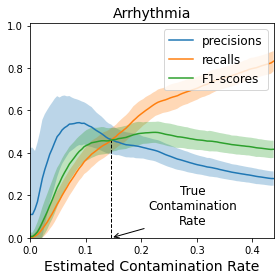

In [5]:
plt.figure(figsize=[4, 4])
plt.axvline(x=true_ratio, ymax=true_precision, color='black', linestyle='dashed', linewidth=1)

plt.plot(ratios, precisions, label='precisions')
plt.fill_between(ratios, precisions+std_p, precisions-std_p, alpha=0.3)

plt.plot(ratios, recalls, label='recalls')
plt.fill_between(ratios, recalls+std_r, recalls-std_r, alpha=0.3)

plt.plot(ratios, f1_scores, label='F1-scores')
plt.fill_between(ratios, f1_scores+std_f, f1_scores-std_f, alpha=0.3)

plt.annotate('True\nContamination\nRate', 
             xy=(true_ratio, 0), 
             xytext=(true_ratio*2, 0.15),
             arrowprops=dict(arrowstyle="->", relpos=(0,0)),
             verticalalignment='center', 
             horizontalalignment='center',
             fontsize=12
            )
plt.legend(loc="upper right", fontsize=12)
plt.xlabel("Estimated Contamination Rate", fontsize=14)
plt.ylim(0, 1.01)
plt.xlim(ratio_min, ratio_max)
plt.title(fig_title[dataset_name], fontsize=14)

plt.tight_layout()
plt.savefig(f"./results/impact_contamination_estimation_{dataset_name}.{img_format}", format=img_format, dpi=dpi)
plt.show()

## ROC and Precision Recall Curves
Builds and plots a ROC curve and a precision recall curve

In [6]:
x, y = load_dataset(dataset_name)
clf = OneClassSVM(gamma="auto", nu=0.9)
x_run, y_run = get_subset(x, y) if dataset_name == "kddcup" else (x.copy(), y.copy())
labels, scores, _ = algo1(x_run, y_run, test_size=0.5, model=clf, compute_metrics=False)

### ROC Curve

In [7]:
fpr, tpr, _ = metrics.roc_curve(labels, scores)
roc_auc = metrics.auc(fpr, tpr)

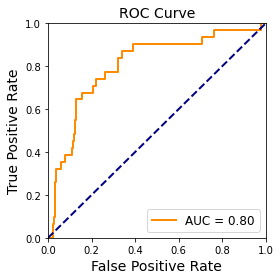

In [8]:
plt.figure(figsize=[4, 4])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw,
         label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title("ROC Curve", fontsize=14)

plt.tight_layout()
plt.savefig(f"./results/ROC_curve_{dataset_name}.{img_format}", format=img_format, dpi=dpi)
plt.show()

### Precision Recall Curve

In [9]:
precision, recall, _ = metrics.precision_recall_curve(labels, scores)
average_precision = metrics.average_precision_score(labels, scores)

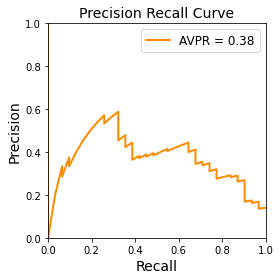

In [10]:
plt.figure(figsize=[4, 4])
lw = 2
plt.plot(recall, precision, color='darkorange', 
         label=f"AVPR = {average_precision:.2f}" , lw=lw)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.title("Precision Recall Curve", fontsize=14)


plt.tight_layout()
plt.savefig(f"./results/Precision_Recall_curve_{dataset_name}.{img_format}", format=img_format, dpi=dpi)
plt.show()